In [1]:
import itertools

import pandas as pd
import numpy as np
import simpy
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import timedelta

In [2]:
with open("data/ger_ci.csv", "r") as f:
    ger = pd.read_csv(f, index_col=0, parse_dates=True)["Carbon Intensity"].rename("Germany")
ger['2020-06-01 00:00:00':]

Time
2020-06-01 00:00:00    170.319207
2020-06-01 00:15:00    171.376437
2020-06-01 00:30:00    173.543319
2020-06-01 00:45:00    175.554316
2020-06-01 01:00:00    175.636264
                          ...    
2021-01-09 22:00:00    521.153048
2021-01-09 22:15:00    517.600964
2021-01-09 22:30:00    514.656596
2021-01-09 22:45:00    510.659998
2021-01-09 23:00:00    508.090652
Name: Germany, Length: 21403, dtype: float64

In [3]:
with open("data/weather_berlin_2021-06.csv", "r") as f:
    solar = pd.read_csv(f, index_col=0, parse_dates=True)["solar"]
solar.index = solar.index - timedelta(days=365)

In [184]:
class Battery:
    """(Way too) simple battery."""
    def __init__(self, capacity, charge_level, max_discharge):
        self.capacity = capacity
        self.charge_level = charge_level
        self.max_discharge = max_discharge

    def update(self, power):
        """Can be called during simulation to feed or draw energy.

        If `energy` is positive the battery is charged.
        If `energy` is negative the battery is discharged.

        Returns the excess energy after the update:
        - Positive if your battery is fully charged
        - Negative if your battery is empty
        - else 0
        """
        self.charge_level += power * 60  # 60 seconds of charging
        excess_power = 0

        abs_max_discharge = self.max_discharge * self.capacity
        if self.charge_level < abs_max_discharge:
            excess_power = (self.charge_level - abs_max_discharge) / 60
            self.charge_level = abs_max_discharge
        elif self.charge_level > self.capacity:
            excess_power = (self.charge_level - self.capacity) / 60
            self.charge_level = self.capacity

        return excess_power

    def soc(self):
        return self.charge_level / self.capacity

class Workload:
    def __init__(self, consumption_in_w):
        self.used_energy = 0
        self.consumption_in_w = consumption_in_w

    def step(self, t_in_min):
        mu, sigma = 0, 5  # mean and standard deviation
        cons = self.consumption_in_w + np.random.normal(mu, sigma)
        self.used_energy += cons * t_in_min * 60
        return cons

In [185]:
def run_simulation(with_logic: bool):
    workload = Workload(consumption_in_w=200)
    battery = Battery(capacity=BATTERY_CAPACITY, charge_level=BATTERY_CHARGE_LEVEL, max_discharge=MAX_DISCHARGE)
    measurements = []  # this will contain the resulting measurements
    env = simpy.Environment()
    env.process(power_usage(env, workload, battery, list(sss / 2), carbon, measurements, with_logic))
    env.run(until=60*24*2)  # env.run(until=100) runs for 100 timesteps only
    print(f"Used energy: {workload.used_energy / 3600 / 1000:.2f} kWh")
    return pd.DataFrame(measurements, index=carbon.index)

Used energy: 9.55 kWh
Used energy: 9.63 kWh
Carbon Emissions: 1.08 kgCO2
Carbon Emissions: 0.89 kgCO2


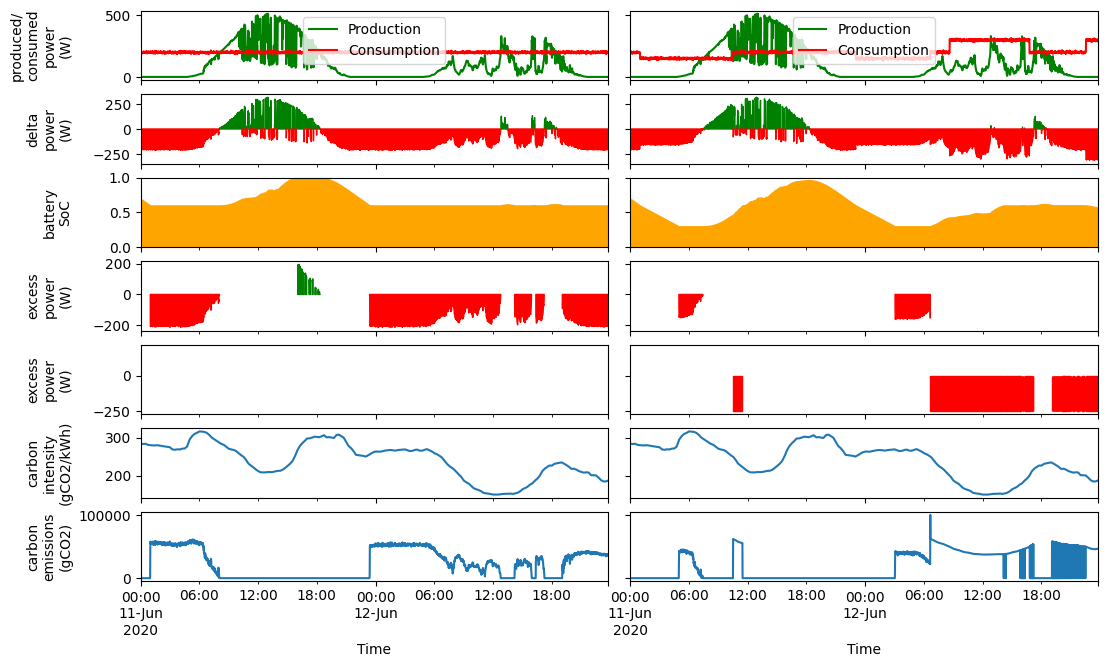

In [193]:
MAX_DISCHARGE = 0.6

def power_usage(env, workload, battery, power_production, carbon, measurements, with_logic):
    # step through the power production (minute by minute)
    for production, carb in zip(power_production, carbon):
        if with_logic:
            battery.max_discharge = 0.3
            if carb >= 250:
                if battery.soc() < MAX_DISCHARGE:
                    workload.consumption_in_w = 150
                else:
                    workload.consumption_in_w = 200
            elif 250 >= carb > 200:
                workload.consumption_in_w = 200
            elif carb <= 200:
                workload.consumption_in_w = 300
            else:
                raise RuntimeError()

        # get current power usage of node
        consumption = workload.step(1)
        delta_power = production - consumption

        # charge/discharge battery
        excess_power = battery.update(delta_power)

        additional_charge_power = 0
        if with_logic and excess_power <= 0 and carb <= 250 and battery.soc() < MAX_DISCHARGE:
            additional_charge_power = 250
            excess_power2 = battery.update(additional_charge_power)
            assert excess_power2 == 0

        # Store measurements
        measurements.append({
            "production_power": production,
            "consumption_power": consumption,
            "delta_power": delta_power,
            "excess_power": excess_power,
            "additional_charge_power": -additional_charge_power,
            "battery_soc": battery.soc(),
        })
        # pause the process for one timestep
        yield env.timeout(1)


def plot_shit(measurements_df, axs):
    measurements_df["production_power"].plot(ax=axs[0], color="green", label="Production")
    measurements_df["consumption_power"].plot(ax=axs[0], color="red", label="Consumption")
    axs[0].set_ylabel("produced/\nconsumed\npower\n(W)")
    axs[0].legend()

    x = measurements_df["delta_power"]
    x.plot(ax=axs[1], alpha=0)  # this call improves performance
    axs[1].fill_between(x.index, 0, x.values, where=x.values>0, color="green")
    axs[1].fill_between(x.index, 0, x.values, where=x.values<0, color="red")
    axs[1].set_ylabel("delta\npower\n(W)")

    x = measurements_df["battery_soc"]
    x.plot(ax=axs[2], alpha=0)  # performance
    axs[2].fill_between(x.index, 0, x.values, color="orange")
    axs[2].set_ylim(0, 1)
    axs[2].set_ylabel("battery\nSoC")

    excess = measurements_df["excess_power"]
    excess.plot(ax=axs[3], alpha=0)  # performance
    axs[3].fill_between(excess.index, 0, excess.values, where=excess.values>0, color="green")
    axs[3].fill_between(excess.index, 0, excess.values, where=excess.values<0, color="red")
    # axs[1].sharey(axs[3])
    axs[3].set_ylabel("excess\npower\n(W)")

    additional_charge = measurements_df["additional_charge_power"]
    excess.plot(ax=axs[4], alpha=0)  # performance
    axs[4].fill_between(additional_charge.index, 0, additional_charge.values, where=additional_charge.values>0, color="green")
    axs[4].fill_between(additional_charge.index, 0, additional_charge.values, where=additional_charge.values<0, color="red")
    # axs[1].sharey(axs[3])
    axs[4].set_ylabel("excess\npower\n(W)")

    carbon.plot(ax=axs[5])
    axs[5].set_ylabel("carbon\nintensity\n(gCO2/kWh)")

    emissions = -(excess + additional_charge) * carbon  # 60 Ws * gCO2/kWh  //  gCO2/60000 // kgCO2/60000/1000
    emissions[emissions < 0] = 0
    emissions.plot(ax=axs[6])
    axs[6].set_ylabel("carbon\nemissions\n(gCO2)")
    print(f"Carbon Emissions: {emissions.sum() / 60000 / 1000:.2f} kgCO2")


BATTERY_CAPACITY = 2000 * 3600  # Ws
BATTERY_CHARGE_LEVEL = BATTERY_CAPACITY * 0.7  # Ws
start, end = "2020-06-11 00:00:00", "2020-06-12"
sss = solar.loc[start:end]
carbon = ger.loc[start:end].resample('1min').interpolate()

measurements_1 = run_simulation(with_logic=False)
measurements_2 = run_simulation(with_logic=True)

fig, axs = plt.subplots(ncols=2, nrows=7, sharex="col", sharey="row", figsize=(10,6))
fig.tight_layout(pad=0)
plot_shit(measurements_1, axs[:,0])
plot_shit(measurements_2, axs[:,1])

fig.align_ylabels()

In [194]:
fig.savefig("../../Latex/2023-wiley-specialissue/ama/figures/evaluation.pdf", dpi=300, bbox_inches='tight')